最近チュートリアルの写経ばっかしている気がする  
というか技術のキャッチアップに手一杯で、それを使って応用するところまでいけてない  
今回はちゃんと応用まで頑張る  
参考URL  
https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

ここから下は上から実行しても動かない

In [204]:
# unsqueezeの挙動確認
a = torch.LongTensor([[1,2],[3,4]])
b = torch.LongTensor([8,6,4,2])
print(a.unsqueeze(1).shape, a.shape)

torch.Size([2, 1, 2]) torch.Size([2, 2])


In [246]:
# torch.bmm(内積)の挙動確認
# batch1, batch2が3D tensorじゃないといけないらしい
# batch1のx軸とbatch2のx軸が等しくて(バッチサイズが等しい)
# batch1のz軸とbatch2のy軸が等しい()
batch1 = torch.randn(1, 10).unsqueeze(0)
batch2 = torch.randn(10, 250).unsqueeze(0)
res = torch.bmm(batch1, batch2)
res.size()

torch.Size([1, 1, 250])

In [140]:
## Embeddingレイヤーの挙動確認
# output_size:2, hidden_size:3
embedding = nn.Embedding(100, 2)
# batch of 2 samples of 4 indices each
input = torch.LongTensor([0, 1,2,1,3, 99])
print(input)
print(embedding(torch.LongTensor([0])))
print(embedding(input))

tensor([  0,   1,   2,   1,   3,  99])
tensor([[ 0.2488,  0.6202]])
tensor([[ 0.2488,  0.6202],
        [ 0.4242, -0.2133],
        [ 0.5858,  0.3303],
        [ 0.4242, -0.2133],
        [-0.5191,  1.4689],
        [ 0.1559, -1.0353]])


In [144]:
## Dropoutレイヤーの挙動確認
m = nn.Dropout(p=0.2)
input = torch.randn(5, 2)
print(input)
print(m(input))

tensor([[ 0.3281,  1.0892],
        [-1.3661,  1.6202],
        [ 0.3010, -0.1736],
        [ 0.6398,  0.9291],
        [ 3.7034,  0.4369]])
tensor([[ 0.0000,  1.3615],
        [-1.7076,  2.0253],
        [ 0.3762, -0.2170],
        [ 0.0000,  1.1613],
        [ 4.6292,  0.5461]])


ここまで

input: フランス語の文章  
output: 英語の文章  

Encoder(GRU)  
1時点に対して1単語ずつ入力  
各時点で出力と隠れ層が出てくる  
文章を最後まで入れ終えると、終わり  
各時点の隠れ層を使用する  

Decoder(GRU + Attention)  
まずスタートの記号、Encoderの最後の隠れ層をAttentionに入力  
Attention_weightが出てくる  
それとencoder_outputsの内積をとる→Weighted sumを計算  
weighetd_sumを少し加工して、prev_hiddenと一緒にGRUに入れる  
GRUが(1, hidden_size)のベクトルを返す(outputであり、hiddenでもある)  
outputの一番高いベクトル

In [1]:
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [2]:
from collections import defaultdict

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
device

device(type='cuda')

In [5]:
SOS_token = 0
EOS_token = 1

SOS: 文章の始まり    
EOS: 文章の終わり  

In [6]:
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = defaultdict(int)
        self.word2count = defaultdict(int)
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2 # count SOS and EOS
        
    def addSentence(self, sentence):
        for word in sentence.split((' ')):
            self.addWord(word)
            
    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] += 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [7]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remoce non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [11]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")
    
    # Read the file and split into lines
    lines = open('../input/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')
    
    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    
    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)
    
    return input_lang, output_lang, pairs

In [12]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m",
    "he is", "he s",
    "she is", "she s",
    "you are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
                len(p[1].split(' ')) < MAX_LENGTH and \
                p[1].startswith(eng_prefixes)
        

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [13]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData("eng", 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Counted words:
fra 4315
eng 3037
['il n est pas ce qu il semble .', 'he is not what he seems .']


The SEQ2SEQ Model

In [14]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hiden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        
        ## embedding: 今回は、wordに割り振った数字をベクトル化して格納するために使う
        # 任意のintが格納されたtorch.LongTensorを入れると、ユニークなベクトルを返す
        # 特にパラメータは存在しない
        # input_size: 語彙数、格納予定の数字の最大値+1(pythonは0から数え始める)
        # hidden_size: 各数字を何次元のベクトルで保存するか
        self.embedding = nn.Embedding(input_size, hidden_size)
        # input_size: hidden_size
        # hidden_size: hidden_size
        # num_layers: 1(多分、default、何層GRUを積み重ねるか)
        self.gru = nn.GRU(hidden_size, hidden_size)
        
    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        ## hidden: encoderの最終層の隠れ層
        # (num_layes(多分1)*num_directions(多分1), batch(1), hidden_size(今回は256))
        # output: (seq_len(今回は1), batch(今回は1), num_directions*hidden_size)
        # 今回はnum_directionsとnum_layersをいじらないので、outputとhiddenは一緒になるはず
        output, hidden = self.gru(output, hidden)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [15]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size= hidden_size
        
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [16]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1,
                 max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        # [embedded, prev_hidden]と横に繋げてLinearに噛ませる
        # Linearはout_dim×in_dimの係数行列 + out_dim行バイアスb
        # Feed-Forward(全結合層)という理解でOK
        # y = x A_t + b
        # Linearの出力は長さmax_length(今回考慮する文章の最大長さ)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        # 今回はoutput_size=hidden_size
        # embeddingでベクトル化したinput単語の次元数と揃える
        self.out = nn.Linear(self.hidden_size, self.output_size)
        
    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        
        attn_weights = F.softmax(
            # [embedded, prev_hidden]と横に繋げてLinearに噛ませる
            # embedded[0]はinput(int)をベクトル化して(1,1,hidden_size)にして[0]にしたもの
            # (1,hidden_size)
            # prev_hiddenは(1, 1, hidden_size), [0]をとるので(1, hidden_size)になる
            # catは結合なので、入力は(1, hidden_size*2)
            # attn_weightsは(1, hidden_size)を入力にとる
            # attn_weightsの出力は(1, max_length)
            # attn_weightsは正負両方の値をもつ
            # softmaxを列方向にとって、正規化する
            # attn_weightsはゼロからディープでいうattention weightsの役割
            # ゼロからディープと少し実装が異なる
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        # attn_weights: (1, max_length)にunsqueeze(0)で先頭に1次元増やす
        # encoder_outputs: (max_len, hidden_size)にunsqueeze
        # bmmはembedded(を元に作ったattn_weight)とencoder_outputsの内積をとる
        # ベクトルの形を見る限り、attn_appliedはcontextベクトル
        # ゼロからディープは内積をとったものをattention weightとしているが、
        # この実装では内積をとったものをweighted sumにしている
        # つまり、input sequenceの特定の箇所の情報を保持し、
        # decoderが正しい出力単語を選ぶ手助けをする
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                encoder_outputs.unsqueeze(0))
        
        # prev_hiddenとattn_appliedを合体させる
        # embedded[0]: (1, 1, hidden_size)の[0]なので(1, hidden_size)
        # attn_applied[0]: (1, 1, hidden_size)の[0]なので(1, hidden_size)
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        # attn_combineは(1, hidden_size)を返す
        output = self.attn_combine(output).unsqueeze(0)
        # ここでreluを入れるということは、
        # embedded→attn_weights→attn_applied→attn_combine(→relu)
        # までの一連の流れが"Attentionレイヤー"という意味を表す、多分
        output = F.relu(output)
        # GRUに、Attentionを噛ませたinputとprev_hiddenを入れる
        # output: (1, hidden_size)
        # hidden: (1, hidden_size)
        output, hidden = self.gru(output, hidden)
        
        # outはLinear, (1, 1, hidden_size)の[0]なので、(1, hidden_size)を入力して
        # (1, n_words)のOne-hot-vectorを返す
        # 最終的な出力単語は、One-hot-vectorの一番値が高い次元のidを選択
        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights
    
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [17]:
def indexesFromSentence(lang, sentence):
    # 半角空白で繋がった文章strを分割して単語のlistにして、単語をindex(int)に変換する
    # 返すのはintが並んだlist
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    # 半角空白で繋がった文章strを、(単語数+1, 1)のindex tensorに変換する
    # index tensor: (文章内単語数, 1)の2次元ベクトル
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token) # EOS_token: 1(int)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    # (フラ語文章, 英語文章)を(フラ語indextensor, 英語indextensor)に変換する
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

Training the Model

"Teacher forcing": Decoderの<SOS>以降の入力を、Decoderの出力ではなく教師データを与える手法  
学習が早くなるが、推論時の結果が不安定になる場合もある

In [18]:
teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, encoder, decoder,
          encoder_optimizer, decoder_optimizer, criterion, 
          max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()
    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    input_length = input_tensor.size(0) # 文章の長さ
    target_length = target_tensor.size(0)
    # encoderの出力を格納するベクトルを作っておく
    # 型は(max_length, hidden_size)で、恐らく
    # encoder_outputs[0]から順に(hidden_size,)の1次元ベクトルを格納
    # encodeがmax_lengthに満たない場合は残りは全て0のまま
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, 
                                  device=device)
    
    loss = 0
    
    # 入力文章の1単語毎にループ
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        # encoder_output[0,0]: (hidden_size, )の長い1次元ベクトル
        encoder_outputs[ei] = encoder_output[0, 0]
    
    # デコーダーの最初のinputを定義
    decoder_input = torch.tensor([[SOS_token]], device=device)
    
    decoder_hidden = encoder_hidden
    
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    
    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        # Targetとなる文章を1単語ずつ入力していく
        # 入力した次の単語が出力されているかlossを計算
        # Targetの単語数分入力をしたら終了
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            # decoder_outputである単語idが、target_tensor[di]の単語idと一致するかを見る
            # 多クラス分類問題
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di] # Tensor forcing
    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hiddden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            # topk: ベクトルの最も大きい要素のvalueと、その値のindexを返す
            # decoder_outputは(1, n_words)のOne-hot-vector
            # 列の次元数がinputの単語のidと結びついている
            # はちゃめちゃなidを返すと次回以降の損失が膨らみ、
            # 正しいidを返すと次回以降の損失が抑えられるので、
            # そうなるように学習をさせる
            topv, topi = decoder_output.topk(1)
            # detach: 勾配を計算するグラフから明示的に演算を切り離す
            # pytorchは自動的に全てのtensor演算を記録している
            # detachは無くても良いが、つけたほうが計算が高速になるらしい
            # squeeze()は次元を消す、引数を指定しないと、1次元ベクトルにする
            decoder_input = topi.squeeze().detach() # detach from histrory as input
            
            # decoder_outputは予測した単語id
            # target_tensor[di]は、output_langのembeddingでテンソル化した単語
            # target_tensorは英語の文章の単語idを並べた(文章内単語数, 1)の2次元ベクトル
            # target_tensor[di]は予測で出てきてほしい単語id(int)
            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break
    
    loss.backward()
    
    encoder_optimizer.step() # たしか、勾配の値を元にパラメータを更新する
    decoder_optimizer.step()
    
    return loss.item() / target_length

In [19]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [20]:
def trainIters(encoder, decoder, n_iters, print_every=1000, 
               plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0 # Reset every print_every
    plot_loss_total = 0 # Reset every plot_every
    
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    # 学習のiter数だけランダムにpairs([フラ語str, 英語str]のペアがたくさん入ったlist)から
    # pairを取り出して、tensorにしたリスト
    training_pairs = [tensorsFromPair(random.choice(pairs)) for i in range(n_iters)]
    criterion = nn.NLLLoss() # 多クラス分類?
    
    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]
        
        loss = train(input_tensor, target_tensor, encoder,
                    decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss
        
        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters), 
                                        iter, iter / n_iters * 100, print_loss_avg))
            
        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
            
    showPlot(plot_losses)

In [26]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts tickes at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

EVALUATION

In [27]:
def evaluate(encoder, decoder, sentence, max_length= MAX_LENGTH):
    # no_gradしている間は勾配計算を行わない
    # つまり、不必要な計算グラフ、パラメータを保持しないので、メモリ節約になる
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()
        
        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, 
                                      device=device)
        
        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], 
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]
        
        decoder_input = torch.tensor([[SOS_token]], device=device)
        
        decoder_hidden = encoder_hidden
        
        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)
        
        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            # decoder_attentionはattntion_weightsを返している
            # decoder_attention.dataが何を表すのか調査、恐らく重みベクトル
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            # 文章終了の合図が出たら終わり
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            # そうでなければ、単語を格納
            else:
                decoded_words.append(output_lang.index2word[topi.item()])
            
            decoder_input = topi.squeeze().detach()
            
        return decoded_words, decoder_attentions[:di + 1]

In [29]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

2m 41s (- 37m 42s) (5000 6%) 2.9904
5m 15s (- 34m 11s) (10000 13%) 2.3835
7m 50s (- 31m 21s) (15000 20%) 2.0631
10m 24s (- 28m 38s) (20000 26%) 1.8198
13m 0s (- 26m 0s) (25000 33%) 1.6234
15m 35s (- 23m 23s) (30000 40%) 1.4727
18m 12s (- 20m 49s) (35000 46%) 1.3267
20m 50s (- 18m 13s) (40000 53%) 1.2013
23m 28s (- 15m 39s) (45000 60%) 1.0825
26m 7s (- 13m 3s) (50000 66%) 1.0188
28m 46s (- 10m 27s) (55000 73%) 0.9322
31m 24s (- 7m 51s) (60000 80%) 0.8761
34m 3s (- 5m 14s) (65000 86%) 0.7947
36m 42s (- 2m 37s) (70000 93%) 0.7598
39m 23s (- 0m 0s) (75000 100%) 0.7059


TypeError: __init__() got an unexpected keyword argument 'bas'

<Figure size 432x288 with 0 Axes>

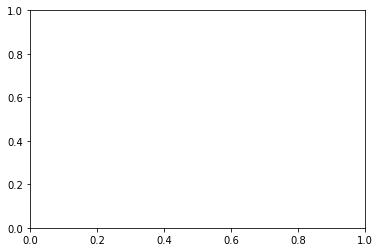

In [24]:
# input_datasetが小さいので、小さいネットワーク、hidden_nodeを256にする
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

In [30]:
evaluateRandomly(encoder1, attn_decoder1)

> elle est fachee la .
= she s upset right now .
< she s right now . <EOS>

> nous en avons fini ici .
= we re finished here .
< we re done here . <EOS>

> elle est au regime .
= she is on a diet .
< she is on a diet . <EOS>

> j ai une dette envers vous .
= i m indebted to you .
< i m indebted to you . <EOS>

> ils sont en bas .
= they re downstairs .
< they re downstairs . <EOS>

> elle est aussi occupee que tom .
= she s as busy as tom .
< she s as busy as tom . <EOS>

> il est dans la lune .
= he is distracted .
< he is distracted . <EOS>

> vous etes maintenant en voie de retablissement .
= you are now on the way to recovery .
< you are now are now now . <EOS>

> il n est pas parfait .
= he isn t perfect .
< he is not perfect . <EOS>

> il craint la mort .
= he is afraid of death .
< he is afraid of death . <EOS>



Visualizing Attention

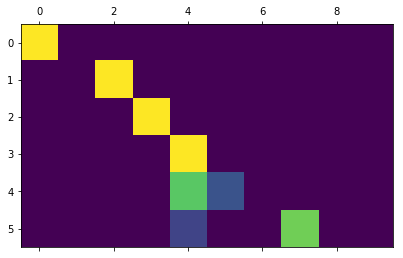

In [50]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "je suis trop froid .")
plt.matshow(attentions.numpy())

je: それは  
suis: be動詞的な？意味はなさそう  
trop: too, あまりにも  
froid: 寒い

列: embedded + prev_hidden  
行: decoder、"<SOS\>"から順番に単語を入れていく  
<SOS\>: je  
i: trop  
m: froid  
too: .  
sensitive: .  
.: prev_hidden[2]←何を表している？


In [34]:
attentions.shape

torch.Size([6, 10])

In [32]:
output_words

['i', 'm', 'too', 'sensitive', '.', '<EOS>']

もうちょい見やすくする  

input = elle a cinq ans de moins que moi .
output = she s six years younger than me . <EOS>
input = elle est trop petit .
output = she is too short . <EOS>
input = je ne crains pas de mourir .
output = i m not afraid to die . <EOS>
input = c est un jeune directeur plein de talent .
output = he s a good young man . <EOS>


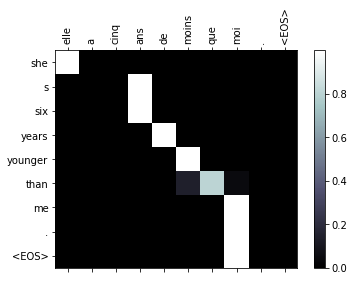

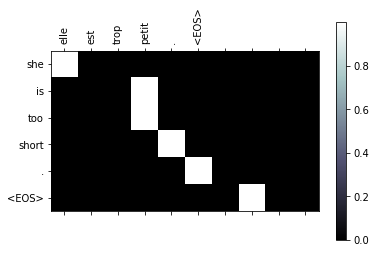

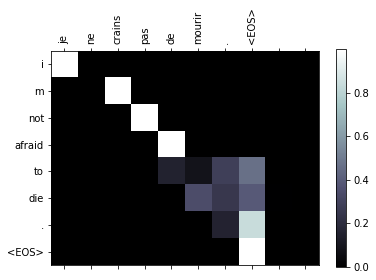

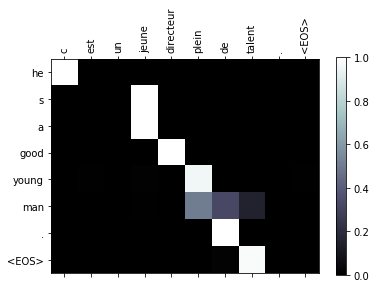

In [51]:
def showAttention(input_sentence, output_words, attentions):
    " Set up figure with colorbar"
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)
    
    # Set up axes
    ax.set_xticklabels([' '] + input_sentence.split(' ') +
                      ['<EOS>'], rotation=90)
    ax.set_yticklabels([' '] + output_words)
    
    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    plt.show()
    

def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print("output =", ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)
    
    
evaluateAndShowAttention("elle a cinq ans de moins que moi .")
evaluateAndShowAttention("elle est trop petit .")
evaluateAndShowAttention("je ne crains pas de mourir .")
evaluateAndShowAttention("c est un jeune directeur plein de talent .")

EmbeddingをGloVeかfaxttextに変えてみる  
InとOutを同じ言語にすれば、autoencoderとして使える  
その場合は、Encoder networkのみを保存して、次に新しいDecoderを準備して学習させる

In [39]:
sentence = "elle a cinq ans de moins que moi ."